# Energy Usage Forecast

In the following project we will create a model with the goal of predicting the energy usage into the future through the algorithem XGBRegressor. 

The lenght of **forecasting horizon** will be one year.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")


In [2]:
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')

In [3]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [5]:
df = df.set_index("Datetime")

In [6]:
df.index = pd.to_datetime(df.index)

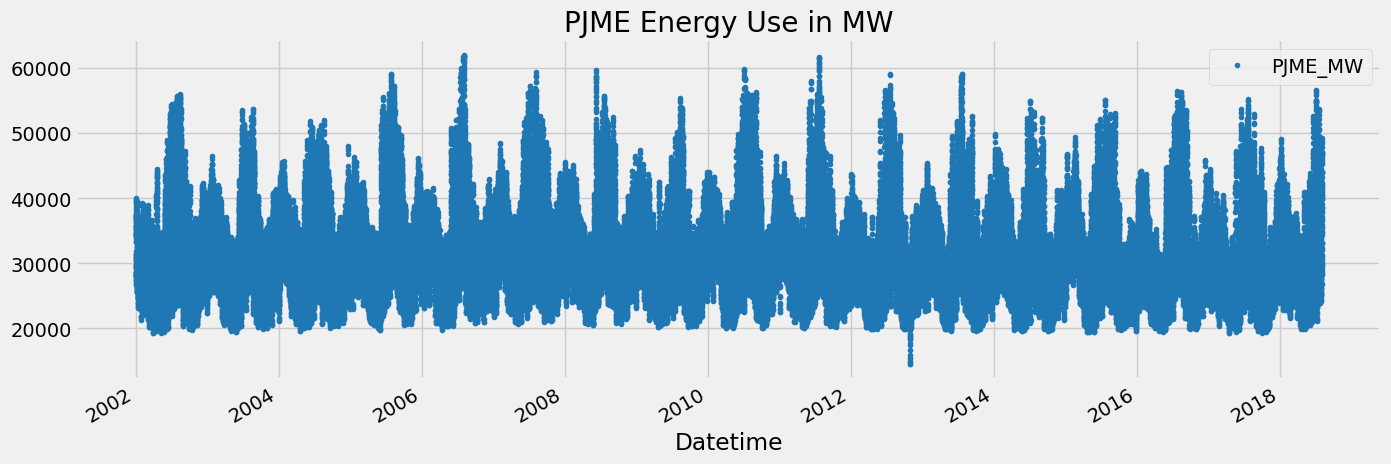

In [7]:
df.plot(style='.', 
        figsize=(15, 5), 
        color = color_pal[0], 
        title='PJME Energy Use in MW')
plt.show()

As you can see there are outliers between 2012 and 2014. The model will learn this outliers so we must remove them. These are numbers below 20.000.

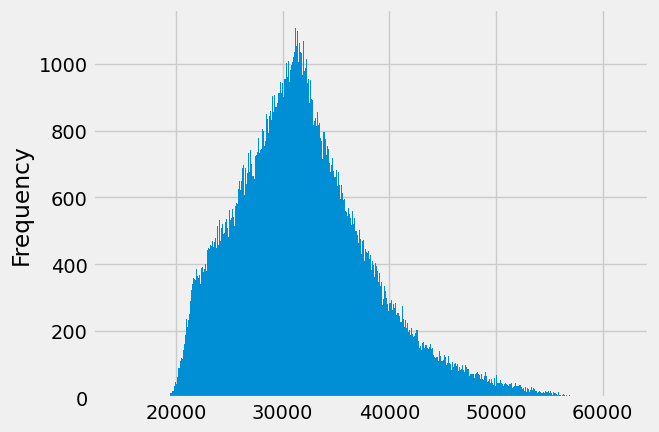

In [8]:
df['PJME_MW'].plot(kind='hist', bins=500)
plt.show()

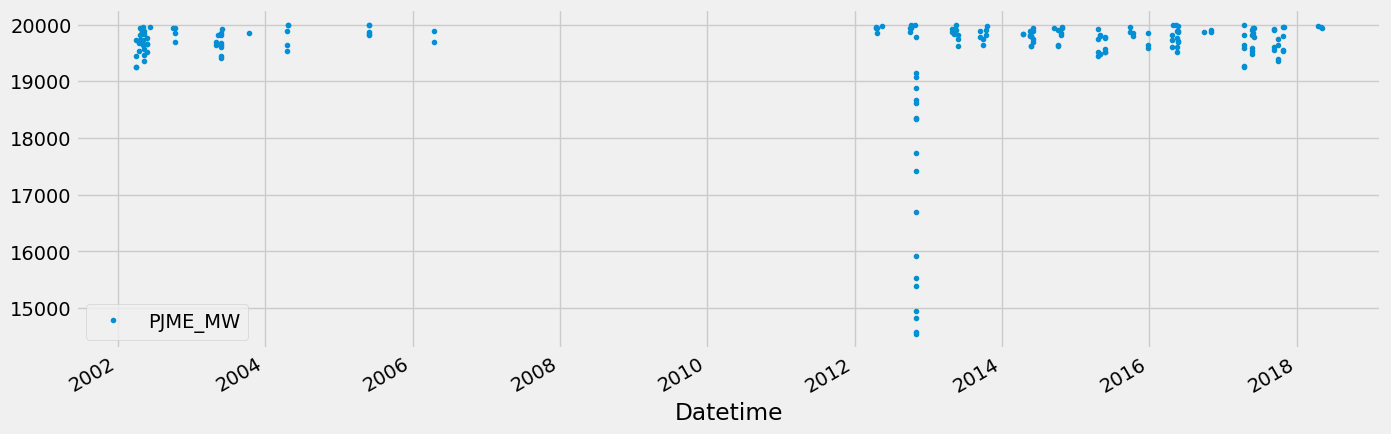

In [9]:
df.query("PJME_MW < 20000").plot(figsize=(15,5), style='.')
plt.show()

A threshold below 19.000 seems to be a better option as you can see in the plot.

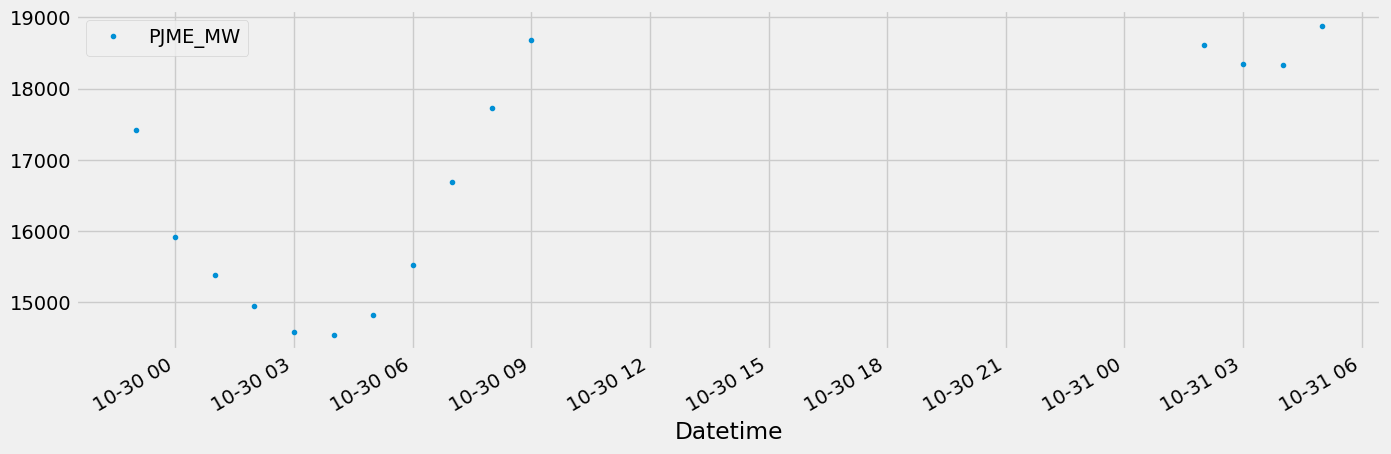

In [10]:
df.query("PJME_MW < 19000").plot(figsize=(15,5), style='.')
plt.show()

In [11]:
# now let's remove the outliers
df = df.query("PJME_MW >= 19000")

## Train/test splits
We are going to split the data on January 2015, so the records before this date will be our training set.

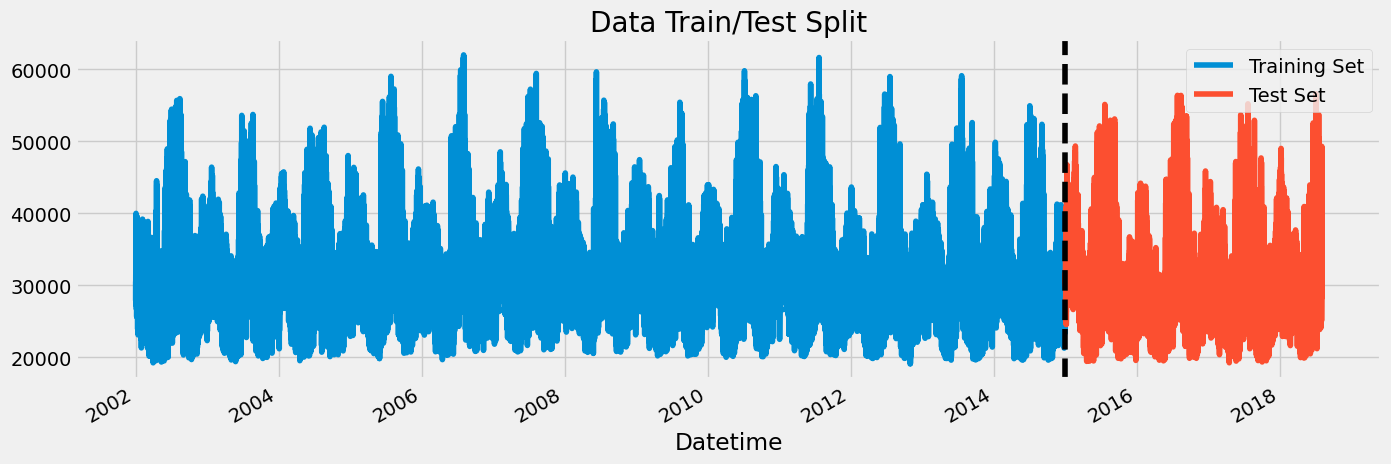

In [12]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']
 
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title = 'Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])

plt.show()

Let's take a look at a single week of data!

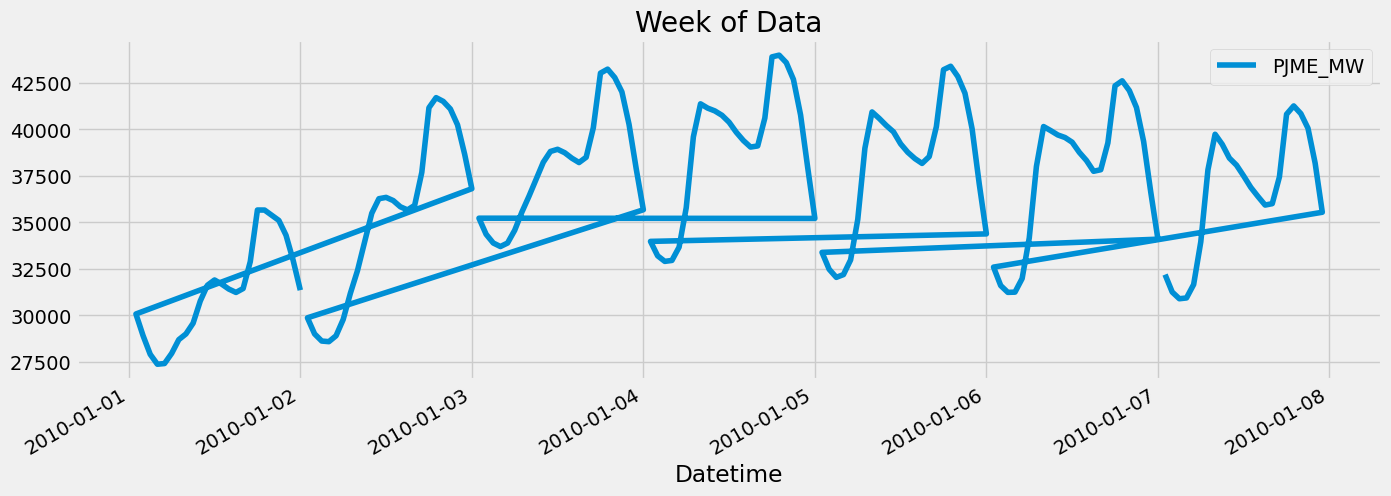

In [13]:
# plot one week of data
single_week = df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')]
single_week.plot(figsize=(15, 5), title = "Week of Data")
plt.show()

For some reason the data doesn't seem to be sorted so let's correct it.

In [14]:
# correct order
df.sort_index(inplace=True)

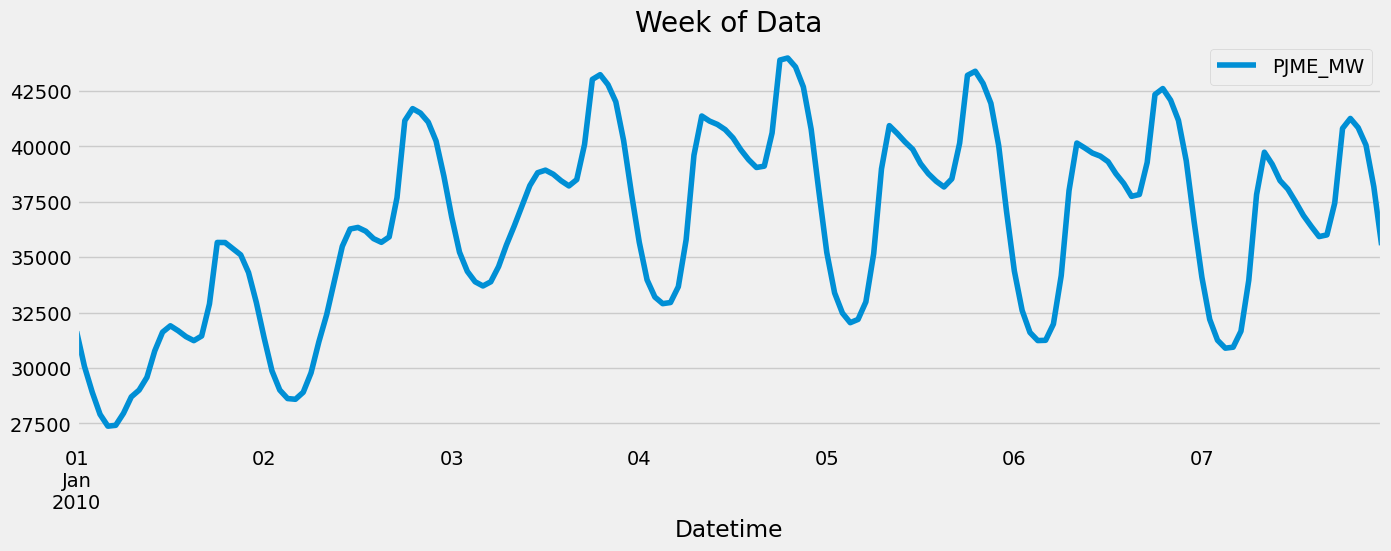

In [15]:
# corrected data display
single_week = df.loc[(df.index >='01-01-2010') & (df.index < '01-08-2010')]
single_week.plot(figsize=(15, 5), title = "Week of Data")
plt.show()

Notice that within each day we can see two main picks which is common in energy consumption and also the valleys during night time.

## Feature Creation!

In [16]:
# Adding new features

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['daysofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return(df)

In [17]:
# Run the function
df = create_features(df)

## Visualze our Feature/Target Relationship

Text(0.5, 1.0, 'MW by hour')

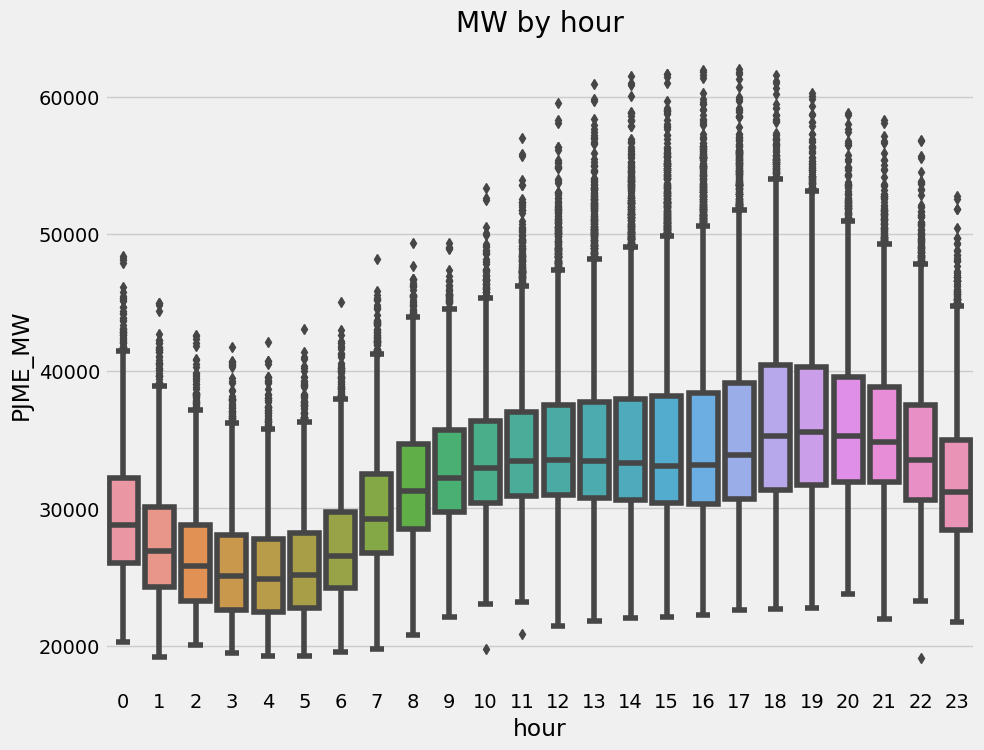

In [18]:
fog, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title("MW by hour")

Here we can see the low usage in the early in the morning that tends to get higher later in the evening.

Text(0.5, 1.0, 'MW by months')

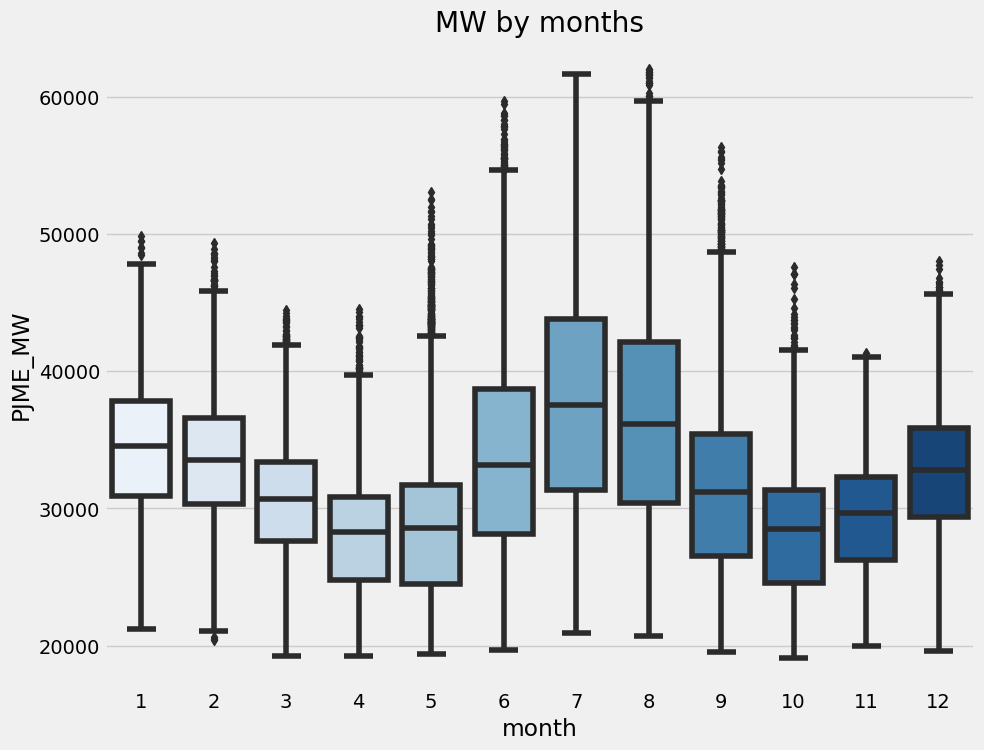

In [19]:
fog, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette = 'Blues')
ax.set_title("MW by months")

Here we can see that the usage by month tends to pick in the winter season, then in fall and spring there is a lower consumption. Then in peaks again in summer prorably due to the air conditioning systems.

## Creating the model!
Here we will create a regression model using the algorithm **XGBRegressor**

In [20]:
train = create_features(train)
test = create_features(test)

In [21]:
df.columns 

Index(['PJME_MW', 'hour', 'daysofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth'],
      dtype='object')

In [22]:
FEATURES = ['hour', 'daysofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = ['PJME_MW']

In [23]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [24]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50, learning_rate= 0.01)
reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100) # print trainiing and eval. score every 100 trees

[0]	validation_0-rmse:6405.28445	validation_1-rmse:6480.13094
[100]	validation_0-rmse:3909.87734	validation_1-rmse:4311.87826
[200]	validation_0-rmse:3243.25262	validation_1-rmse:3865.72569
[300]	validation_0-rmse:2995.46635	validation_1-rmse:3745.78494
[400]	validation_0-rmse:2827.84032	validation_1-rmse:3742.79426
[408]	validation_0-rmse:2816.47317	validation_1-rmse:3743.82357


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature Importance

In [25]:
feature_importance = pd.DataFrame(reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['importance'])

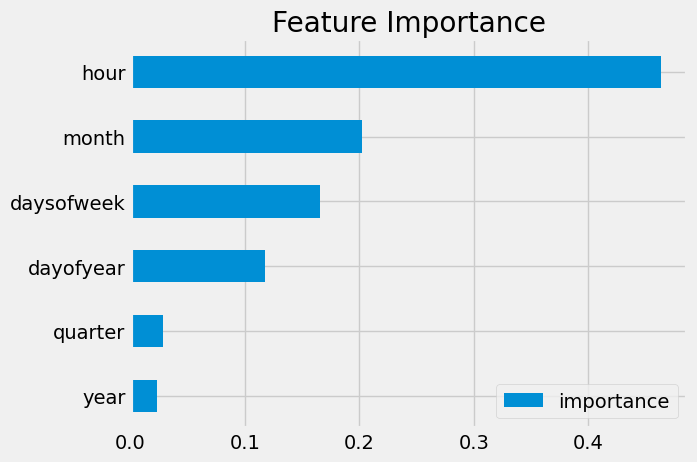

In [26]:
feature_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast on Test

In [27]:
# create prediction colum and add it to the original DF
test['predictions'] = reg.predict(X_test)
df = df.merge(test[['predictions']], how='left', left_index=True, right_index=True)


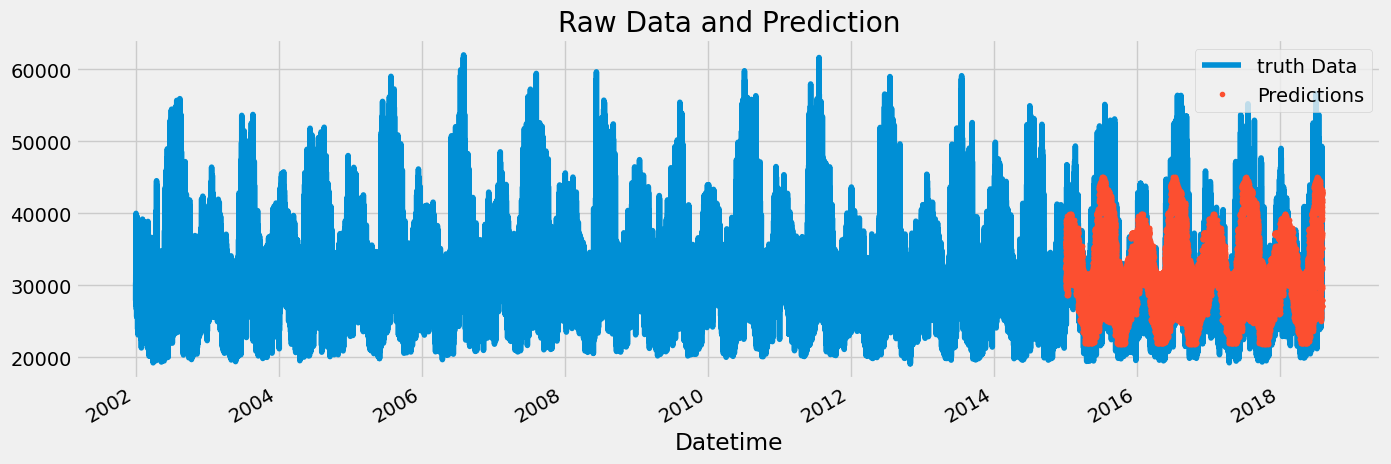

In [28]:
# Display predictions
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['predictions'].plot(ax=ax, style='.')
plt.legend(['truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

 Now let's take a look at a week of predictions!

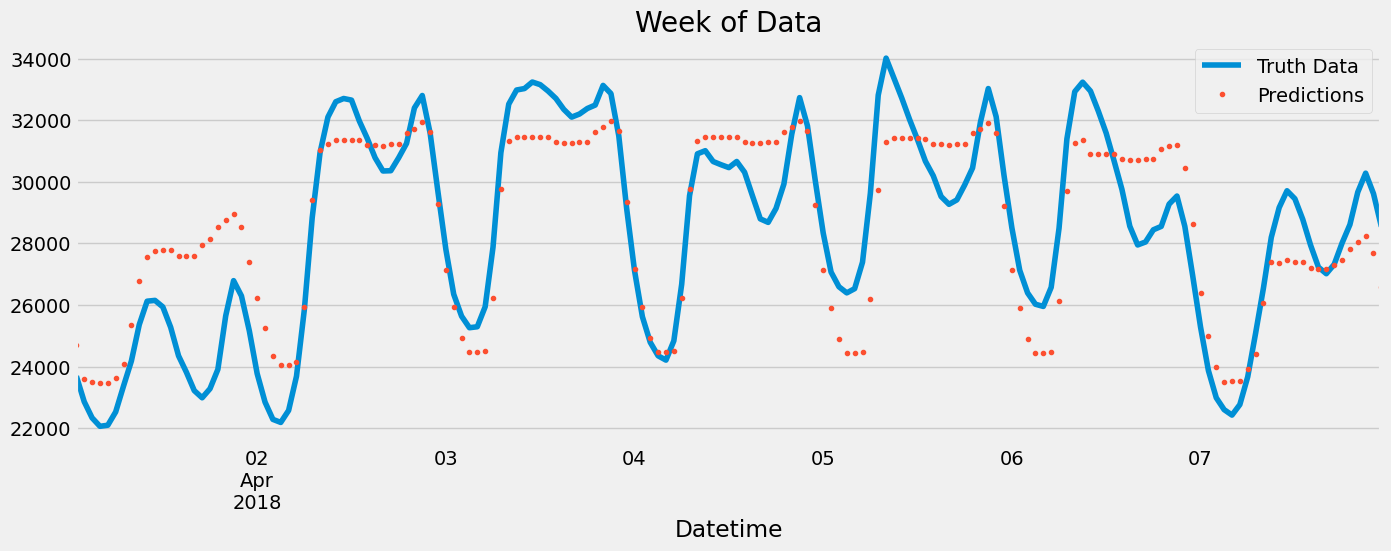

In [29]:
# display week
ax = df.loc[(df.index >'04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title = "Week of Data")

df.loc[(df.index >'04-01-2018') & (df.index < '04-08-2018')]['predictions'] \
    .plot(style='.')
plt.legend(['Truth Data', 'Predictions'])

plt.show()

**As you can see there's a lot of improvement that an be done. However, the predictions on the test set in this week follow the trend we would spect to see.**

## Calculate RMSE

In [30]:
# Root MSE
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['predictions']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3735.60


## Calculate the Error
Look at worst and best predicted points

In [31]:
test['error'] = np.abs(test['PJME_MW'] - test['predictions'])
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=False).head(15)

date
2016-08-13    13660.265137
2016-08-14    13390.762451
2016-09-10    11317.800863
2016-09-09    11004.110270
2016-08-12    10599.099121
2018-01-06    10412.568929
2015-02-20    10172.527995
2017-05-19     9461.556234
2016-07-04     9447.765137
2015-02-16     9375.572103
2018-01-07     9336.074951
2016-07-23     9313.164795
2017-12-31     9006.554036
2016-08-11     8962.048665
2015-02-21     8834.506429
Name: error, dtype: float64

## Next steps
- Create a more robust cross validation
- Lag Features
- Predict the future

### Time Series Cross Validation

In [32]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

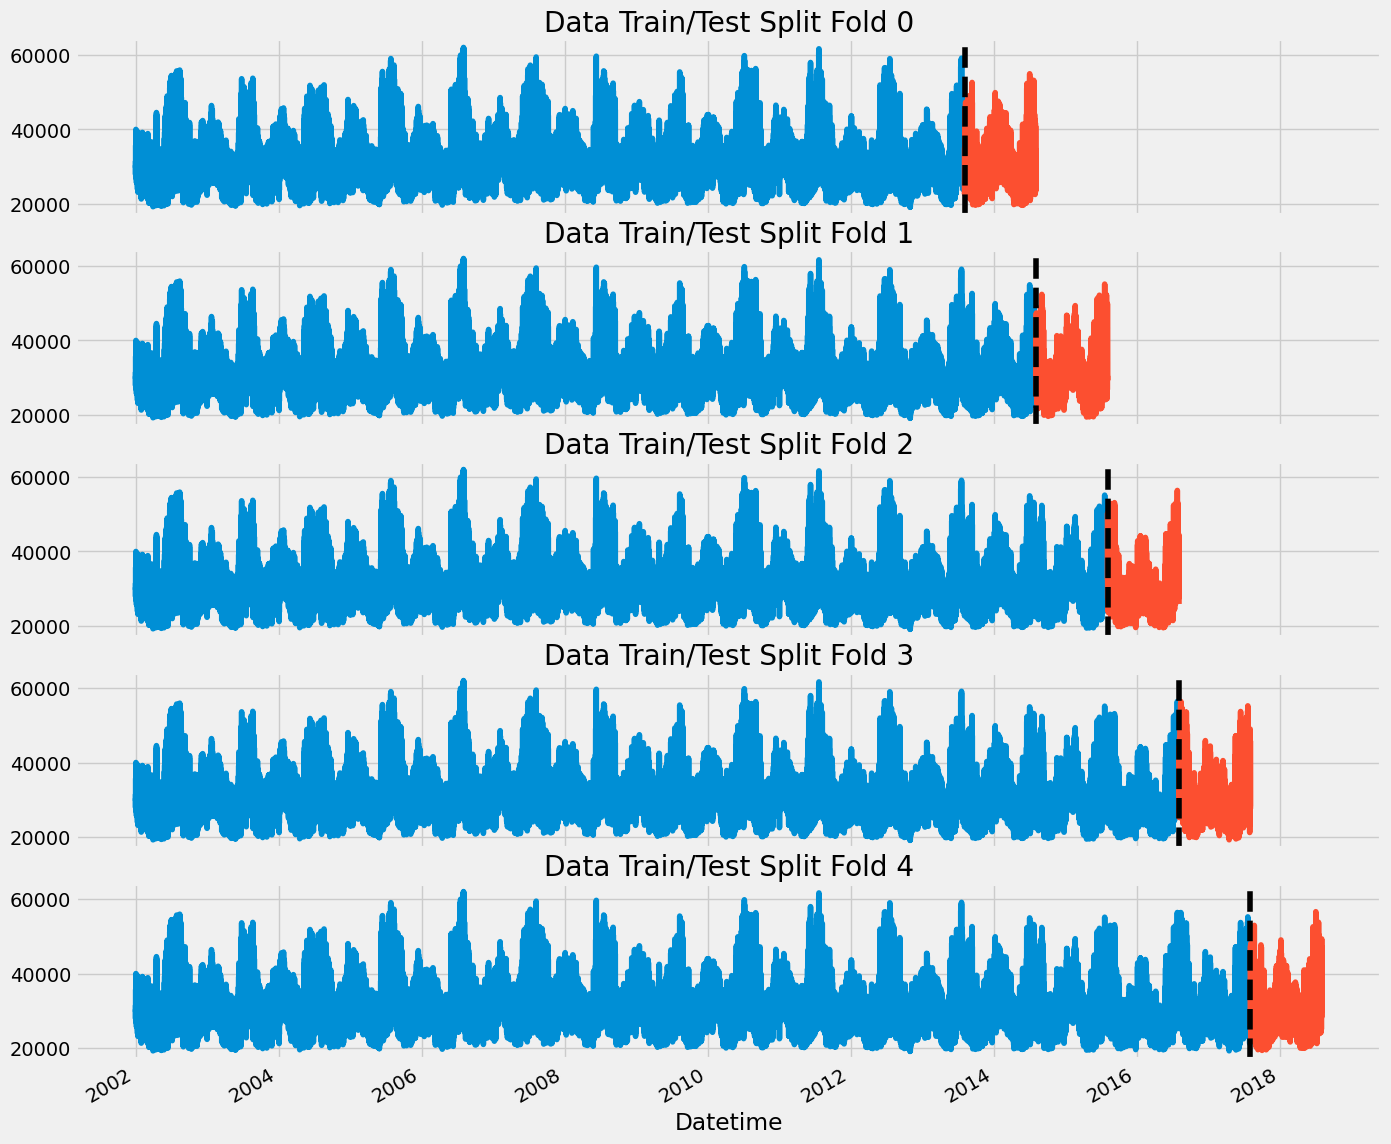

In [33]:
# plot crossed validation
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()
    

## Lag Features
- What was the target days in th past

In [34]:
# Remove previous predictions
df = df[['PJME_MW', 'hour', 'daysofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth']]

In [35]:
# Add lag features
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map) # why 364 and not 365. because it is divisible by 7 and it'll give you the exact same day of the week without the need of mapping.
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('192 days')).map(target_map)
    return(df)

In [36]:
# Adding lag variables
df = add_lags(df)

In [37]:
df

,PJME_MW,hour,daysofweek,quarter,month,year,dayofyear,dayofmonth,lag1,lag2,lag3
Datetime,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,42256.0,41485.0,33512.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,41210.0,40249.0,32614.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,39525.0,38698.0,31075.0


We got lag features that empty because there is no way to compute those lags in the farthest days back in history, which is normal.

## Train Using Cross Validation

In [38]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'daysofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.30088	validation_1-rmse:31957.08096


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:31:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12546.31175	validation_1-rmse:12044.84055
[200]	validation_0-rmse:5760.19182	validation_1-rmse:5510.95523
[300]	validation_0-rmse:3911.96495	validation_1-rmse:3966.91668
[400]	validation_0-rmse:3488.96176	validation_1-rmse:3780.57349
[500]	validation_0-rmse:3369.75059	validation_1-rmse:3774.50835
[544]	validation_0-rmse:3340.70875	validation_1-rmse:3778.56134
[0]	validation_0-rmse:32671.76899	validation_1-rmse:32142.13679


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:31:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12526.14407	validation_1-rmse:12187.24550
[200]	validation_0-rmse:5771.36534	validation_1-rmse:5525.74606
[300]	validation_0-rmse:3935.68224	validation_1-rmse:3794.70921
[400]	validation_0-rmse:3519.79780	validation_1-rmse:3485.30059
[500]	validation_0-rmse:3401.62148	validation_1-rmse:3421.80151
[600]	validation_0-rmse:3343.83156	validation_1-rmse:3386.61211
[700]	validation_0-rmse:3302.12620	validation_1-rmse:3371.92073
[800]	validation_0-rmse:3268.49179	validation_1-rmse:3358.29773
[900]	validation_0-rmse:3235.75185	validation_1-rmse:3338.61136
[999]	validation_0-rmse:3206.60706	validation_1-rmse:3325.23244
[0]	validation_0-rmse:32630.97735	validation_1-rmse:31069.98153


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:31:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12508.84503	validation_1-rmse:11153.23932
[200]	validation_0-rmse:5766.35447	validation_1-rmse:4845.04161
[300]	validation_0-rmse:3935.74432	validation_1-rmse:3592.57052
[393]	validation_0-rmse:3539.54339	validation_1-rmse:3573.72817
[0]	validation_0-rmse:32528.18588	validation_1-rmse:31474.51358


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:31:57] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12474.12673	validation_1-rmse:12051.57183
[200]	validation_0-rmse:5758.66705	validation_1-rmse:5788.29095
[300]	validation_0-rmse:3936.53003	validation_1-rmse:4354.68600
[400]	validation_0-rmse:3530.63677	validation_1-rmse:4143.44055
[500]	validation_0-rmse:3415.88287	validation_1-rmse:4087.80598
[600]	validation_0-rmse:3360.20799	validation_1-rmse:4068.92317
[656]	validation_0-rmse:3337.29311	validation_1-rmse:4071.76141
[0]	validation_0-rmse:32461.76096	validation_1-rmse:31462.58329


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:32:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12457.00837	validation_1-rmse:12006.96288
[200]	validation_0-rmse:5774.11086	validation_1-rmse:5724.31987
[300]	validation_0-rmse:3971.68805	validation_1-rmse:4308.65901
[400]	validation_0-rmse:3570.96704	validation_1-rmse:4138.22630
[487]	validation_0-rmse:3469.02645	validation_1-rmse:4131.19533


In [39]:
print(f'Mean score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Mean score across folds 3765.3915
Fold scores:[3773.415137430688, 3325.2324377415543, 3541.2443814775206, 4067.2786346758926, 4119.786738630747]


## Creating a new DF to predict  the future!

Now we will train the model one more time with all of the training data. This is an important step because after we have done this train/validation split for time series we still need to leverage all the data that we have to forecast into the future.

In [40]:
# Retrain on all data

df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'daysofweek', 'quarter', 'month','year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = train[FEATURES]
y_all = train[TARGET]
    
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=500,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32461.76096


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:32:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12457.00837
[200]	validation_0-rmse:5774.11086
[300]	validation_0-rmse:3971.68805
[400]	validation_0-rmse:3570.96704
[499]	validation_0-rmse:3459.98084


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

Here we'll create a new DataFrame with **a year of predictions(2019)**.

In [41]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

Here we'll create a DF with the predictions

In [42]:
# create future dataframe 
future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [43]:
future_w_features = df_and_future.query('isFuture').copy()

In [44]:
future_w_features

,PJME_MW,hour,daysofweek,quarter,month,year,dayofyear,dayofmonth,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,33539.0,32094.0,27008.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,30781.0,29503.0,25625.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,29015.0,27712.0,24831.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,27884.0,26535.0,24496.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,27223.0,25870.0,24497.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,46912.0,39352.0,NaN,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,45985.0,38699.0,NaN,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,44094.0,37346.0,NaN,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,40666.0,34555.0,NaN,True


## Predicting the Future

In [45]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

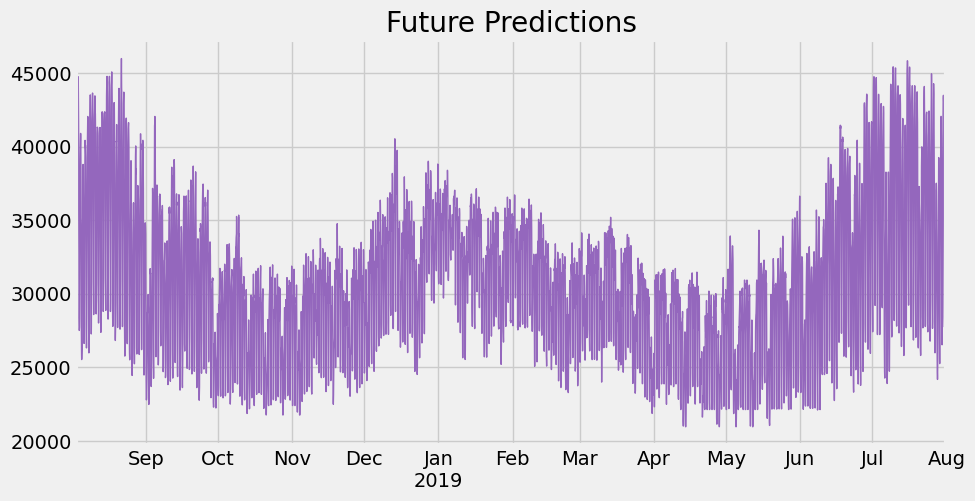

In [46]:
# Plotting predictions
future_w_features['pred'].plot(figsize=(10, 5), 
                               color=color_pal[4],
                               ms = 1,
                               lw = 1,
                               title = 'Future Predictions'
                                )
plt.show()

This plot represents one year of predictions as established in the forecasting horizon!

## Saving the model

In [47]:
reg.save_model('model.json')

In [48]:
!ls -lh

total 560K
-rw-r--r-- 1 root root 558K May 17 02:33 model.json
